In [1]:
import numpy as np
from math import *
import os
import time
import xml.etree.ElementTree as et
import random
from random import randint


In [2]:

# Debug level
VERBOS = True

def sphere(x):
   size, dim = x.shape
   y = np.array(np.sum(np.power(x,2), axis=1)).reshape(size,1)
   return(y)

def rosenbrock(x):
   size, dim = x.shape
   y = np.sum(100 * np.power(x[:,1:dim] - np.power(x[:,0:dim-1],2), 2) + np.power(x[:,0:dim-1] - 1, 2), axis=1).reshape(size,1)
   return(y)

def ackley(x):
   size, dim = x.shape
   y = np.array(-20 * np.exp(-0.2 * np.sqrt((np.sum(np.power(x,2), axis=1))/dim)) - np.exp(np.sum(np.cos(2 * np.pi * x), axis=1) / dim) + np.exp(1)).reshape(size,1)
   return(y)

def griewanks(x):
   size, dim = x.shape
   y = np.array(np.sum(np.power(x, 2)/4000, axis=1) - np.prod(np.cos(x/np.sqrt(np.arange(dim) + 1)), axis = 1) + 1).reshape(size,1)
   return(y)

def rastrigin(x):
   size, dim = x.shape
   y = np.array(np.sum(np.power(x, 2) - 10 * np.cos(2 * np.pi * x), axis = 1) + 10 * dim).reshape(size, 1)
   return(y)

benchmarks = {'sphere':sphere , 'ackley':ackley, 'rosenbrock':rosenbrock, 'griewanks':griewanks, 'rastrigin':rastrigin}
f = 'sphere'
if f == 'sphere':
   xmax =  100
elif f == 'ackley':
   xmax = 32.768
elif f == 'rosenbrock':
   xmax = 2.048
elif f == 'griewanks':
   xmax = 600
elif f == 'rastrigin':
   xmax = 5.12


# Context vector
def context_vector(best, swarm, x):
   best[:,swarm] = x
   return(best)

# Action selection
def actionselection(action, probability, numactions, numdims):
   for i in range(numdims):
      a = np.random.choice(np.arange(0, numactions), p = probability[:,i])
      mask = np.zeros(numactions,dtype=bool)
      mask[a] = True
      action[mask,i] = 1
      action[~mask,i] = 0
   return(action)

# Update probabilities
def probabilityupdate(action, probability, numactions, numdims, signal, alpha, beta):
   for i in range(numdims):
      a = np.where(action[:,i] == 1)
      mask = np.zeros(numactions,dtype=bool)
      mask[a] = True
      if not signal:
         probability[mask,i] = probability[mask,i] + alpha * (1 - probability[mask,i])
         probability[~mask,i] = (1 - alpha) * probability[~mask,i]
      else:
         probability[mask,i] = (1 - beta) * probability[mask,i]
         probability[~mask,i] = (beta/(numactions-1)) + (1-beta) * probability[~mask,i]
   return(probability)

# Maximum iterations
imax = 1000
# Acceleration coefficients
c1   = 1.49445
c2   = 1.49445
# Weight
wmax = 0.9
wmin = 0.4
# Number of dimensions
dim  = 30
# Population size
size = 50
# Enumeration size
efactor = 2/3
# TDR constraints
numswarms = 4

# Elite size
esize = size - round(size * efactor)

# Max and min position bounds
xmax =  100
xmin = -xmax

# Max and min velocity bounds
vmax = 0.2 * (xmax - xmin)
vmin = -vmax

# TDR constraints
k1 = dim % numswarms
k1len = ceil(dim/numswarms)
k2 = numswarms - k1
k2len = floor(dim/numswarms)
tdrtable = np.zeros((1, dim))
index = np.zeros((1, dim))
if(k1):
   for i in range(k1):
      for j in range(k1len):
         tdrtable[0,(i*k1len)+j] = i

   for i in range(k2):
      for j in range(k2len):
         tdrtable[0,(k1*k1len)+(i*k2len)+j] = k1+i
else:
   for i in range(k2):
      for j in range(k2len):
         tdrtable[0,(i*k2len)+j] = i


# Position
x    = np.zeros((size, dim))
x    = xmin + ((xmax - xmin) * np.random.rand(size, dim))

# Velocity
v    = np.zeros((size, dim))
v    = vmin + ((vmax - vmin) * np.random.rand(size, dim))

# Fitness
fx   = np.zeros((size,1))
fx   = benchmarks[f](x)

# Personal best position
pb   = np.zeros((size, dim))
fpb  = np.zeros((size, 1))
pb   = np.copy(x)
fpb  = np.copy(fx)

# Global best position
gb   = np.zeros((1, dim))
fgb  = 0
gb   = np.copy(x[np.argmin(fx), :].reshape(1,dim))
fgb  = np.copy(fx[np.argmin(fx)]).reshape(1,1)

alpha = 0.1
beta = 0.1

numactions = numswarms
action = np.zeros((numactions, dim))
probability = np.tile(1/numactions, (numactions, dim))
#stat = []
#stat.append(fgb[0,0])
#stat1 = []
#stat1.append(fgb1[0,0])
#print('Iteration', i, 'Global best', fgb[0,0])

# Main loop for updating particles
for i in range(imax):
   w = wmax - (((wmax - wmin) / imax) * i) # Small step size
   action = actionselection(action, probability, numactions, dim)
   for j in range(numswarms):
      signal = 1
      a = np.arange(dim)
      swarm = a[action[j,:] == 1]
      swarmsize = len(swarm)

      if swarmsize:
         swarm = swarm.reshape(1,swarmsize)
         ind = np.argsort(fx,  axis=0)
         for kk in range(size):
            k = ind[kk]
            v[k,swarm] = (w * v[k,swarm]) + (c1 * np.random.rand(1, swarmsize) * (pb[k,swarm] - x[k,swarm])) + (c2 * np.random.rand(1, swarmsize) * (gb[0,swarm] - x[k,swarm]))
            x[k,swarm] = x[k,swarm] + v[k,swarm]
            fx[k,0] = benchmarks[f](x[k,:].reshape(1,dim))
            fxcv  = benchmarks[f](context_vector(np.copy(gb), swarm, x[k,swarm]))
            fpbcv = benchmarks[f](context_vector(np.copy(gb), swarm, pb[k,swarm]))
            if(fxcv < fpbcv):
               pb[k,swarm]  = x[k,swarm]
               fpb[k,0] = benchmarks[f](pb[k,:].reshape(1,dim))
            if(fxcv < fgb):
               gb[0,swarm] = x[k,swarm]
               fgb = benchmarks[f](gb.reshape(1,dim))
               signal = 0
            if VERBOS:
               print('  Population 1: Iteration', i, 'Global best', fgb[0,0])
      probability = probabilityupdate(action, probability, numactions, dim, signal, alpha, beta)


Streaming output truncated to the last 5000 lines.
  Population 1: Iteration 975 Global best 2.211734702853633e-85
  Population 1: Iteration 975 Global best 2.211734702853633e-85
  Population 1: Iteration 975 Global best 2.211734702853633e-85
  Population 1: Iteration 975 Global best 2.211734702853633e-85
  Population 1: Iteration 975 Global best 2.211734702853633e-85
  Population 1: Iteration 975 Global best 2.211734702853633e-85
  Population 1: Iteration 975 Global best 2.211734702853633e-85
  Population 1: Iteration 975 Global best 2.211734702853633e-85
  Population 1: Iteration 975 Global best 2.211734702853633e-85
  Population 1: Iteration 975 Global best 2.211734702853633e-85
  Population 1: Iteration 975 Global best 2.211734702853633e-85
  Population 1: Iteration 975 Global best 2.211734702853633e-85
  Population 1: Iteration 975 Global best 2.211734702853633e-85
  Population 1: Iteration 975 Global best 2.211734702853633e-85
  Population 1: Iteration 975 Global best 2.211734702

Streaming output truncated to the last 5000 lines.
  Population 1: Iteration 975 Global best 2.79809078570918e-178
  Population 1: Iteration 975 Global best 2.79809078570918e-178
  Population 1: Iteration 975 Global best 2.79809078570918e-178
  Population 1: Iteration 975 Global best 2.79809078570918e-178
  Population 1: Iteration 975 Global best 2.654610116857006e-178
  Population 1: Iteration 975 Global best 2.654610116857006e-178
  Population 1: Iteration 975 Global best 2.654610116857006e-178
  Population 1: Iteration 975 Global best 2.654610116857006e-178
  Population 1: Iteration 975 Global best 2.654610116857006e-178
  Population 1: Iteration 975 Global best 2.654610116857006e-178
  Population 1: Iteration 975 Global best 2.654610116857006e-178
  Population 1: Iteration 975 Global best 2.654610116857006e-178
  Population 1: Iteration 975 Global best 2.654610116857006e-178
  Population 1: Iteration 975 Global best 2.654610116857006e-178
  Population 1: Iteration 975 Global best 2

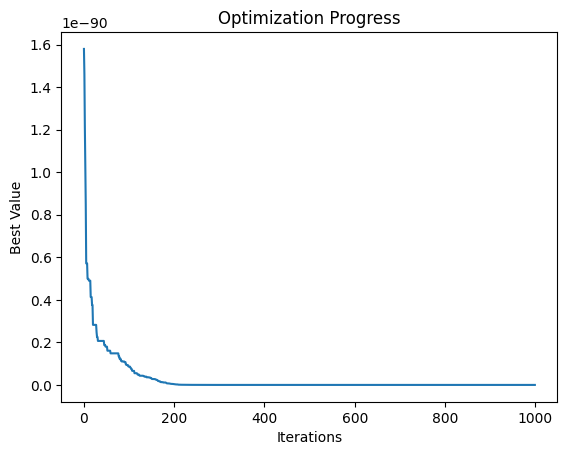

In [3]:

import matplotlib.pyplot as plt

# تعداد تکرارها
iterations = range(imax)
# بهترین مقدار یافت شده در هر تکرار
best_values = []

# Main loop for updating particles
for i in range(imax):
   w = wmax - (((wmax - wmin) / imax) * i) # Small step size
   action = actionselection(action, probability, numactions, dim)
   for j in range(numswarms):
      signal = 1
      a = np.arange(dim)
      swarm = a[action[j,:] == 1]
      swarmsize = len(swarm)

      if swarmsize:
         swarm = swarm.reshape(1,swarmsize)
         ind = np.argsort(fx,  axis=0)
         for kk in range(size):
            k = ind[kk]
            v[k,swarm] = (w * v[k,swarm]) + (c1 * np.random.rand(1, swarmsize) * (pb[k,swarm] - x[k,swarm])) + (c2 * np.random.rand(1, swarmsize) * (gb[0,swarm] - x[k,swarm]))
            x[k,swarm] = x[k,swarm] + v[k,swarm]
            fx[k,0] = benchmarks[f](x[k,:].reshape(1,dim))
            fxcv  = benchmarks[f](context_vector(np.copy(gb), swarm, x[k,swarm]))
            fpbcv = benchmarks[f](context_vector(np.copy(gb), swarm, pb[k,swarm]))
            if(fxcv < fpbcv):
               pb[k,swarm]  = x[k,swarm]
               fpb[k,0] = benchmarks[f](pb[k,:].reshape(1,dim))
            if(fxcv < fgb):
               gb[0,swarm] = x[k,swarm]
               fgb = benchmarks[f](gb.reshape(1,dim))
               signal = 0
            if VERBOS:
               print('  Population 1: Iteration', i, 'Global best', fgb[0,0])
      probability = probabilityupdate(action, probability, numactions, dim, signal, alpha, beta)

   # ثبت بهترین مقدار یافت شده در این تکرار
   best_values.append(fgb[0,0])

# نمایش نمودار
plt.plot(iterations, best_values)
plt.xlabel('Iterations')
plt.ylabel('Best Value')
plt.title('Optimization Progress')
plt.show()
